# Example about LLM tokenizers

In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer, AutoModel, AutoModelForCausalLM)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import pandas as pd

## Tokenizers

In [2]:
# Tokenizers can be loaded with
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Models can be loaded with 
model = AutoModel.from_pretrained("gpt2")

/Users/aappopulkkinen/repos/llm-finetuning-public/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# Encoding can be done with encode method or via calling the tokenizer callable
print(tokenizer.encode("Hello, this is my test sentence."))

print(tokenizer("Hello, this is my test sentence."))

# Decoding can be done with the decode method
print(tokenizer.decode([15496, 11, 428, 318, 616, 1332, 6827, 13]))

[15496, 11, 428, 318, 616, 1332, 6827, 13]
{'input_ids': [15496, 11, 428, 318, 616, 1332, 6827, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Hello, this is my test sentence.


### TODO
Try out different tokenizer. Do you notice some differences? You can try for instance "gpt2", "distilbert-base-uncased" or "facebook/galactica-1.3b" and convert text to tokens and tokens back to text.

## Models

In [4]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Inference can be done with the model directly
input_text = "Test"
model_output = model(**tokenizer(input_text, return_tensors="pt"))
print(model_output)

# In this case the model output is the last hidden state of the model. GPT2 model is missing a head that would convert the data into something meanignful.

BaseModelOutputWithPastAndCrossAttentions(last_hidden_state=tensor([[[-5.0457e-02, -4.3747e-02, -3.1824e-01,  2.0617e-02, -2.4952e-02,
          -1.5509e-01,  1.9821e+00, -1.5205e-01, -2.2764e-01, -3.0758e-02,
           3.2163e-01, -1.0552e-01,  4.1639e-02, -4.8358e-03, -3.4070e-01,
          -7.3504e-02, -1.6134e-01, -1.5813e-01,  5.0896e-02, -3.0002e-01,
           5.1374e-02, -1.0251e-01, -2.8810e-01,  3.6918e-02, -1.3385e-01,
           6.0123e-02, -4.6923e-02, -2.3209e-01, -1.1755e-02, -3.8960e-01,
           8.7105e-02, -6.3499e-02, -5.9899e-02, -2.0604e-01, -9.1302e-02,
           2.7079e-02,  1.8662e+01, -3.8295e-02, -1.0102e-01, -4.8659e-02,
          -6.2648e-02,  1.0094e-01, -1.3147e-02, -3.4589e-01, -1.0056e-01,
           1.0917e-01,  6.8494e-03,  5.1276e-02, -3.1201e-01, -5.2111e-02,
          -5.0684e-02,  1.7032e-01, -4.3341e-01, -1.2776e-01, -3.5364e-02,
          -8.6371e-02, -6.0714e-02, -2.2974e-01, -1.2168e-01,  1.7980e-01,
           8.3924e-02, -4.1534e-02,  2.0

In [5]:
# Use AutomodelForCausalLM instead to load a model with causal language model head (i.e. text generation)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Inference produces now "meaningful" text
input_text = "The weather is nice today because"

# Notice that generate method is used instead of calling the model directly, when usign the causal language model
model_output = model.generate(**tokenizer(input_text, return_tensors="pt"), max_length=20)
print(tokenizer.decode(model_output[0]))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The weather is nice today because it's sunny and it's warm. I'm not sure if it


## TODO

Try the gpt2 model out a bit. The performance seems not to be great, or what do you think? How do you find out how many parameters there are in the model and what is the memory footprint?


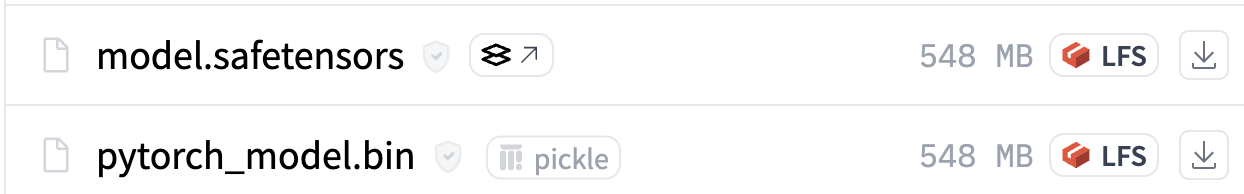

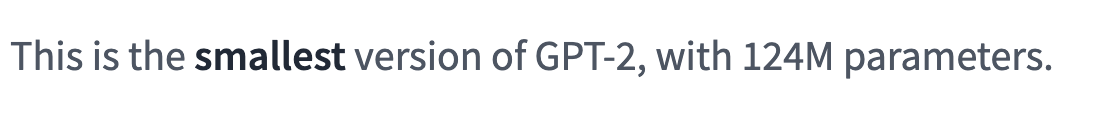

## Padding and truncation

### TODO

Try how right/left sided padding and truncation works with tokenizers.

In [6]:
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [7]:
# We set the pad token to be the same as eos token which is
tokenizer.encode(tokenizer.eos_token)

[50256]

In [8]:
# Try padding and truncation with different settings
tokenizer("Hello, this is my test sentence.", padding="max_length", max_length=10, truncation=True)

{'input_ids': [15496, 11, 428, 318, 616, 1332, 6827, 13, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 0, 0]}

## TODO
Test how left/right padding affects the model output.

In [9]:
input_texts = [
    "The weather is nice today because",
    "The president of the United States is the person",
    "I don't like the movie because"]

In [10]:
tokenizer.padding_side = "left"

# AutomodelForCausalLM can be used instead to load a model with causal language model head (i.e. text generation)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Inference produces now "meaningful" text
input_ids = tokenizer(input_texts, return_tensors="pt", padding=True)
model_output = model.generate(**input_ids, max_length=20)
for i, output in enumerate(model_output):
    print(f"Output nr {i}")
    print(tokenizer.decode(output))


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output nr 0
<|endoftext|><|endoftext|><|endoftext|>The weather is nice today because it's sunny and it's warm. I'm not
Output nr 1
The president of the United States is the person who is responsible for the decision to send the troops to
Output nr 2
<|endoftext|><|endoftext|>I don't like the movie because it's so much more about the characters and the world
